Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[INFO] loading images...
938
['Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vessel Tortuosity'
 'Vessel Tortuosity' 'Vessel Tortuosity' 'Vesse

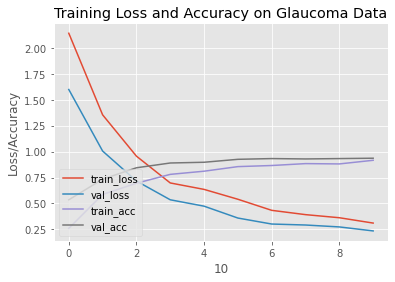

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

from google.colab import drive
drive.mount('/content/gdrive')
file_path = '/content/gdrive/MyDrive/Machine Learning/Project Glaucoma/'
dataset_path = os.path.join(os.path.dirname(file_path), 'Glaucoma_Dataset')


INIT_LR=1e-3
EPOCHS = 10
BS = 30

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(dataset_path))
imagePaths = list(paths.list_images(f"{dataset_path}"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

print(len(data))
np.save(file_path + 'Glaucoma_Dataset/Glaucoma_features_data.npy',data)
np.save(file_path + 'Glaucoma_features_labels.npy',labels)

data=np.load(file_path + 'Glaucoma_Dataset/Glaucoma_features_data.npy')
labels=np.load(file_path + 'Glaucoma_features_labels.npy')
print(labels)
lb = LabelBinarizer()
labelsx = lb.fit_transform(labels)
#labelsx = labelsx[:]
print(lb.classes_)
(trainX, testX, trainY, testY) = train_test_split(data, labelsx, test_size=0.30, random_state=42)
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

baseModel = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(10, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False
model.summary()


opt=Adam()
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX)/BS,
    validation_data=(testX, testY),
    validation_steps=len(testX),
    epochs=EPOCHS )
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Glaucoma Data")
plt.xlabel(N)
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

def myfunc(a):
  return lb.classes_[a]
y_predz = model.predict(testX, batch_size=BS, verbose=1)
y_pred = np.argmax(y_predz, axis=1)
predicted_Labels = map(myfunc, y_pred)
print(list(lb.inverse_transform(testY))[:])
#print(np.fromiter(predicted_Labels))
print(classification_report(list(lb.inverse_transform(testY))[:],list(predicted_Labels)[:]))


In [ ]:
# np.savetxt("Y_test.csv",y_test,delimiter=',')
# np.savetxt("Y_pred.csv",y_pred,delimiter=',')

In [ ]:
#predicted_Labels = map(myfunc, y_pred)

In [8]:
from sklearn.metrics import confusion_matrix
y_test = np.argmax(testY, axis=1)

conf_mtrx = confusion_matrix(y_test, y_pred)

In [9]:
# Functions to compute True Positives, True Negatives, False Positives and False Negatives

def true_positive(y_true, y_pred):
    
    tp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 1:
            tp += 1
    return tp

def true_negative(y_true, y_pred):
    tn = 0
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 0:
            tn += 1
    return tn

def false_positive(y_true, y_pred):
    fp = 0
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 1:
            fp += 1
    return fp

def false_negative(y_true, y_pred):
    fn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 0:
            fn += 1
    return fn

In [10]:
#Computation of macro-averaged precision

def macro_precision(y_true, y_pred):

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize precision to 0
    precision = 0
    
    # loop over all classes
    for class_ in list(y_true):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        
        
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        # keep adding precision for all classes
        precision += temp_precision
        
    # calculate and return average precision over all classes
    precision /= num_classes
    
    return precision

In [11]:
print(f"Macro-averaged Precision score : {macro_precision(y_test, y_pred) }")

Macro-averaged Precision score : 26.520117451545463


In [12]:
from sklearn import metrics

macro_averaged_precision = metrics.precision_score(y_test, y_pred, average = 'macro')

In [13]:
print(f"Macro-Averaged Precision score using sklearn library : {macro_averaged_precision}")

Macro-Averaged Precision score using sklearn library : 0.9458107902949608


In [14]:
def micro_precision(y_true, y_pred):


    # find the number of classes 
    num_classes = len(np.unique(y_true))
    
    # initialize tp and fp to 0
    tp = 0
    fp = 0
    
    # loop over all classes
    for class_ in y_true:
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        # calculate true positive for current class
        # and update overall tp
        tp += true_positive(temp_true, temp_pred)
        
        # calculate false positive for current class
        # and update overall tp
        fp += false_positive(temp_true, temp_pred)
        
    # calculate and return overall precision
    precision = tp / (tp + fp)
    return precision

In [15]:
print(f"Micro-averaged Precision score : {micro_precision(y_test, y_pred)}")

Micro-averaged Precision score : 0.9336080047086521


In [16]:
micro_averaged_precision = metrics.precision_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged Precision score using sklearn library : {micro_averaged_precision}")

Micro-Averaged Precision score using sklearn library : 0.9361702127659575


In [17]:
macro_averaged_recall = metrics.recall_score(y_test, y_pred, average = 'macro')
print(f"Macro-averaged recall score using sklearn : {macro_averaged_recall}")

Macro-averaged recall score using sklearn : 0.9403940915705622


In [18]:
micro_averaged_recall = metrics.recall_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged recall score using sklearn library : {micro_averaged_recall}")

Micro-Averaged recall score using sklearn library : 0.9361702127659575


In [19]:
macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged F1 score using sklearn library : {macro_averaged_f1}")

Macro-Averaged F1 score using sklearn library : 0.9412603899750487


In [20]:
micro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged F1 score using sklearn library : {micro_averaged_f1}")

Micro-Averaged F1 score using sklearn library : 0.9361702127659575


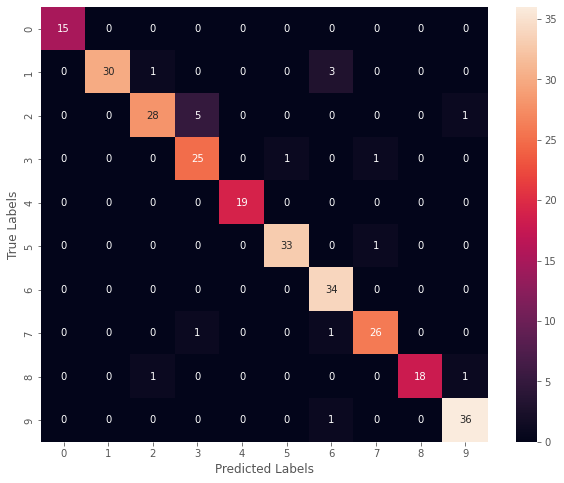

In [21]:
import seaborn as sns
plt.figure(figsize = (10,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot = True)#, xticklabels = y_test, yticklabels = y_test, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#Dict[list(map(myfunc, y_test))[1]] = list(map(myfunc, y_test))[1]
Dict

{}

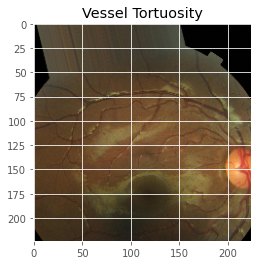

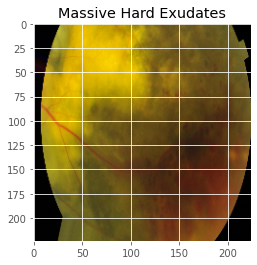

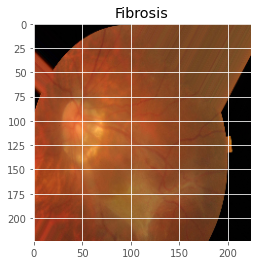

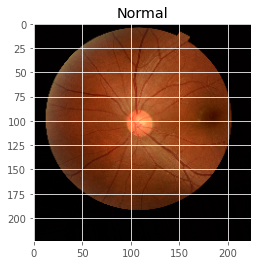

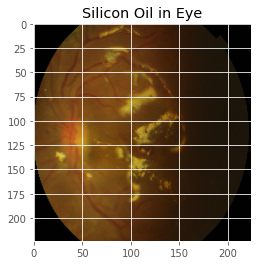

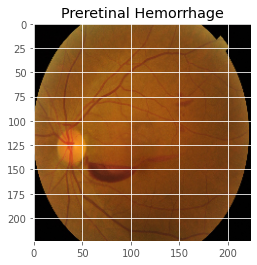

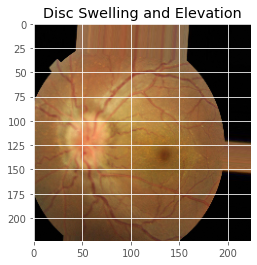

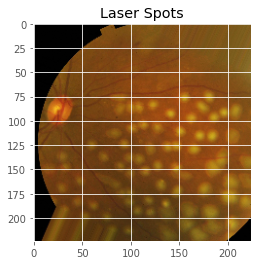

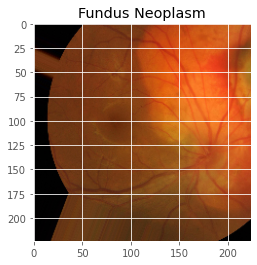

In [22]:
Dict={}
for i in range(30):
  if list(map(myfunc, y_test))[i] not in Dict:
    Dict[list(map(myfunc, y_test))[i]] = list(map(myfunc, y_test))[i]
    plt.imshow(testX[i])
    plt.title(list(map(myfunc, y_test))[i])
    plt.show()
    

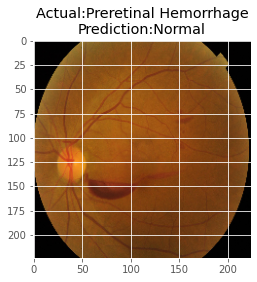

In [23]:
plt.imshow(testX[8])
plt.title('Actual:'+ list(map(myfunc, y_test))[8] + '\n' + 'Prediction:'+ list(map(myfunc, y_pred))[8])
plt.show()

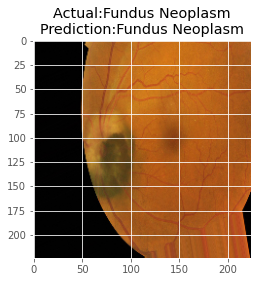

In [24]:
plt.imshow(testX[35])
plt.title('Actual:'+ list(map(myfunc, y_test))[35] + '\n' + 'Prediction:'+ list(map(myfunc, y_pred))[35])
plt.show()